In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDataset
from train_factor_vae import train_factor_VAE

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)
imgs = dataset["imgs"]

In [3]:
data = CustomDataset(imgs,20000)

In [4]:
data_train, data_test = train_test_random_split(data, 0.8)

Length of training data : 16000
Length of testing data : 4000


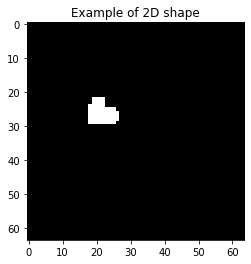

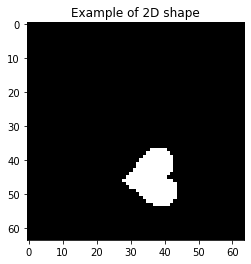

In [5]:
print("Length of training data :",len(data_train))
print("Length of testing data :",len(data_test))

for i in [0, -1]:
    im, _ = data_train[i]
    im = im.squeeze()
    plt.imshow(im, cmap='Greys_r')
    plt.title("Example of 2D shape")
    plt.show()

In [6]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

Epoch 1:
training vae loss of 717.4514375
training recon loss of 710.765125
training kld loss of 6.686546875
training TC loss of 0.06844580078125
training discriminator loss of 0.6669276123046874
Epoch 2:
training vae loss of 557.91575
training recon loss of 556.0935
training kld loss of 1.82206982421875
training TC loss of 0.33793499755859374
training discriminator loss of 0.6153172607421875
Epoch 3:
training vae loss of 455.78603125
training recon loss of 448.8595
training kld loss of 6.92643798828125
training TC loss of 1.286818603515625
training discriminator loss of 0.4107687683105469
Epoch 4:
training vae loss of 294.73828125
training recon loss of 283.99659375
training kld loss of 10.74196484375
training TC loss of 1.4783662109375
training discriminator loss of 0.3584933776855469
Epoch 5:
training vae loss of 181.809203125
training recon loss of 169.97446875
training kld loss of 11.83464453125
training TC loss of 1.1923048095703126
training discriminator loss of 0.41102642822265

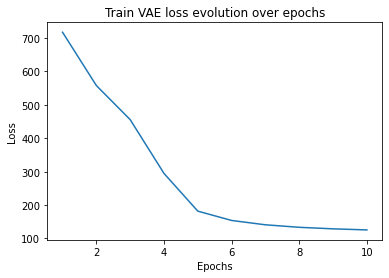

In [7]:
model = FactorVAEDSprites()
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
VAE_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
gamma = 0
nb_epochs = 10

train_factor_VAE(model, discriminator, VAE_optimizer, discriminator_optimizer, gamma, nb_epochs, train_loader, True)

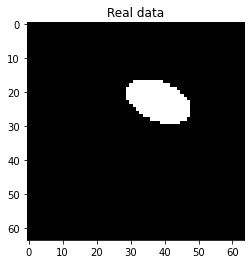

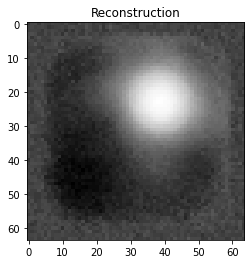

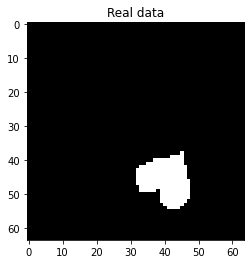

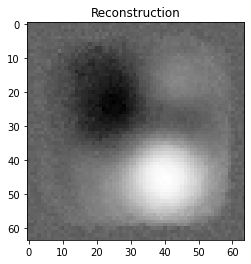

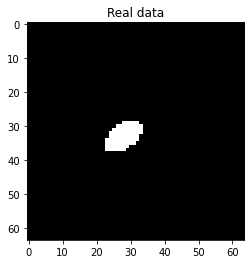

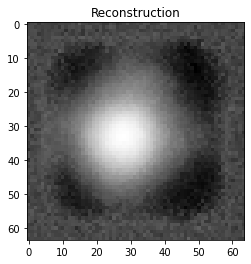

In [8]:
with torch.no_grad():
    for i in [1,15,20]:
        data, _ = data_test[i]
        data = data.unsqueeze(1)
        recon, mu, logvar, z = model(data)
        data = data.squeeze()
        recon = recon.squeeze()
        plt.imshow(data, cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(recon, cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()

In [9]:
dataset.allow_pickle = True
latents_sizes = dataset['metadata'][()][b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, fixed = None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        if fixed == lat_i:
            fixed_value = np.random.randint(lat_size, size=1)
            samples[:, lat_i] = np.full(size, fixed_value)
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

In [10]:
def compute_latent_variance(size):
    sample = sample_latent(size)
    imgs_sampled = imgs[latent_to_index(sample)]
    latents = np.zeros((size,10))
    for i,data in enumerate(imgs_sampled):
        data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
        recon, mu, logvar, z = model(data)
        z = np.array(z.squeeze().detach().numpy())
        latents[i] = z
    global_vars = np.var(latents, axis = 0) 
    return global_vars

latents_global_variance = compute_latent_variance(1000)


In [11]:
def FactorVAE_entanglement_metric(nb_samples,sample_size):
    loss = 0
    classification = np.zeros((len(latents_sizes),10))
    for i in range(nb_samples):
        k = np.random.randint(len(latents_sizes)-1)+1
        latents_sampled = sample_latent(size=sample_size, fixed=k)
        indices_sampled = latent_to_index(latents_sampled)
        imgs_sampled = imgs[indices_sampled]
        latents_rep = np.zeros((sample_size,10))
        for data in imgs_sampled:
            data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
            recon, mu, logvar, z = model(data)
            z = np.array(z.squeeze().detach().numpy())
            latents_rep[i] = z
        latents_var = np.var(latents_rep, axis = 0) 
        latents_var_normalized = np.divide(latents_var, latents_global_variance)
        idx = np.argmin(latents_var_normalized)
        classification[k,idx]+=1
    print(classification)
    for i in range(len(latents_sizes)):
        loss = loss + np.sum(classification[i])- np.max(classification[i])
    return loss/nb_samples

In [12]:
FactorVAE_entanglement_metric(50,500)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 0. 2. 1. 2. 1. 2. 1. 1. 1.]
 [1. 2. 2. 1. 3. 0. 1. 0. 0. 2.]
 [2. 1. 0. 1. 2. 0. 0. 2. 1. 0.]
 [0. 0. 1. 3. 1. 1. 0. 2. 2. 0.]]


0.78